# **1. Import Libraries**

In [1]:
# import libraries
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import pandas_profiling
import os
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

C:\Users\Sahil\AppData\Local\Temp\ipykernel_11732\43271641.py:9: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling


# **2. Load the Files**

In [2]:
# training files
train_proteins = pd.read_csv("train_proteins.csv")
train_peptides = pd.read_csv("train_peptides.csv")
train_clinical = pd.read_csv("train_clinical_data.csv")

# **3. Proteins Data**

In [3]:
# proteins training data
print("Proteins Training Data has", train_proteins.shape[0], "rows and", train_proteins.shape[1], "columns")
train_proteins.head()

Proteins Training Data has 232741 rows and 5 columns


,visit_id,visit_month,patient_id,UniProt,NPX
0,55_0,0,55,O00391,11254.3
1,55_0,0,55,O00533,732430.0
2,55_0,0,55,O00584,39585.8
3,55_0,0,55,O14498,41526.9
4,55_0,0,55,O14773,31238.0


In [4]:
# print the number of null values in each column
print(train_proteins.isnull().sum())

visit_id       0
visit_month    0
patient_id     0
UniProt        0
NPX            0
dtype: int64


# **4. Peptides Data**

In [5]:
# peptides training data
print("Peptides Training Data has", train_peptides.shape[0], "rows and", train_peptides.shape[1], "columns")
train_peptides.head()

Peptides Training Data has 981834 rows and 6 columns


,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7


In [6]:
# print the number of null values in each column
print(train_peptides.isnull().sum())

visit_id            0
visit_month         0
patient_id          0
UniProt             0
Peptide             0
PeptideAbundance    0
dtype: int64


# **5. Clinical Data**

In [7]:
# clinical training data
print("Clinical Training Data has", train_clinical.shape[0], "rows and", train_clinical.shape[1], "columns")
train_clinical.head()

Clinical Training Data has 2615 rows and 8 columns


,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,NaN,NaN
1,55_3,55,3,10.0,7.0,25.0,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,NaN,NaN
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On


In [8]:
# print the number of null values in each column
print(train_clinical.isnull().sum())

visit_id                                  0
patient_id                                0
visit_month                               0
updrs_1                                   1
updrs_2                                   2
updrs_3                                  25
updrs_4                                1038
upd23b_clinical_state_on_medication    1327
dtype: int64


# **6. Preprocess the Proteins and Clinical Data**

In [9]:
# pivot the proteins data
train_proteins = train_proteins.pivot(index = ['visit_id', 'visit_month', 'patient_id'], columns = 'UniProt', values = 'NPX').reset_index().rename_axis(None, axis = 1)
train_proteins.head()

,visit_id,visit_month,patient_id,O00391,O00533,O00584,O14498,O14773,O14791,O15240,...,Q9HDC9,Q9NQ79,Q9NYU2,Q9UBR2,Q9UBX5,Q9UHG2,Q9UKV8,Q9UNU6,Q9Y646,Q9Y6R7
0,10053_0,0,10053,9104.27,402321.0,NaN,NaN,7150.57,2497.84,83002.9,...,NaN,9469.45,94237.6,NaN,23016.0,177983.0,65900.0,15382.0,NaN,19017.40
1,10053_12,12,10053,10464.20,435586.0,NaN,NaN,NaN,NaN,197117.0,...,NaN,14408.40,NaN,NaN,28537.0,171733.0,65668.1,NaN,9295.65,25697.80
2,10053_18,18,10053,13235.70,507386.0,7126.96,24525.7,NaN,2372.71,126506.0,...,317477.0,38667.20,111107.0,NaN,37932.6,245188.0,59986.1,10813.3,NaN,29102.70
3,10138_12,12,10138,12600.20,494581.0,9165.06,27193.5,22506.10,6015.90,156313.0,...,557904.0,44556.90,155619.0,14647.9,36927.7,229232.0,106564.0,26077.7,21441.80,7642.42
4,10138_24,24,10138,12003.20,522138.0,4498.51,17189.8,29112.40,2665.15,151169.0,...,NaN,47836.70,177619.0,17061.1,25510.4,176722.0,59471.4,12639.2,15091.40,6168.55


In [10]:
# drop the visit month and patient id columns and also drop all the proteins that have null values (to prevent overfitting)
train_proteins = train_proteins.dropna(axis = 1).drop(columns = ['visit_month', 'patient_id'])
train_proteins.head()

,visit_id,O15240,P01009,P01011,P01023,P01024,P01042,P01834,P01876,P02647,...,P02790,P05090,P06396,P07602,P10909,P23142,P41222,Q12805,Q92520,Q9UHG2
0,10053_0,83002.9,12825300.0,1084770.0,1005230.0,2669740.0,541909.0,2440800.0,1874270.0,4032650.0,...,3858400.0,4087060.0,1352720.0,731854.0,4749780.0,822784.0,42511700.0,1051980.0,322496.0,177983.0
1,10053_12,197117.0,11871200.0,1135570.0,1230990.0,3360790.0,584371.0,2030500.0,1800070.0,5111760.0,...,3708010.0,3491420.0,1390950.0,618772.0,4223100.0,661058.0,34100500.0,738247.0,496976.0,171733.0
2,10053_18,126506.0,14319900.0,1444430.0,1333940.0,3728860.0,971184.0,2106740.0,1508300.0,5713180.0,...,4773570.0,5096710.0,2232400.0,879126.0,5728010.0,971421.0,38324600.0,843926.0,674551.0,245188.0
3,10138_12,156313.0,11024900.0,1725440.0,1302590.0,4276570.0,1627070.0,4071840.0,5456100.0,22825800.0,...,6629400.0,5233080.0,2535650.0,1204390.0,7528540.0,1246230.0,34148900.0,816347.0,601869.0,229232.0
4,10138_24,151169.0,14145200.0,1544440.0,1221060.0,4570310.0,1301680.0,2421520.0,3032880.0,11136600.0,...,2628690.0,3852520.0,2443370.0,459165.0,8704760.0,1274950.0,45982800.0,598882.0,569973.0,176722.0


In [11]:
# fill the null values inside the proteins data
for (columnName, columnData) in train_proteins.iteritems():
    # check if the column has any null values
    if (train_proteins[columnName].isnull().values.any()):
        # fill the null values with the mean value of the column
        train_proteins[columnName].fillna(train_proteins[columnName].mean(), inplace = True)
        
train_proteins.head()

,visit_id,O15240,P01009,P01011,P01023,P01024,P01042,P01834,P01876,P02647,...,P02790,P05090,P06396,P07602,P10909,P23142,P41222,Q12805,Q92520,Q9UHG2
0,10053_0,83002.9,12825300.0,1084770.0,1005230.0,2669740.0,541909.0,2440800.0,1874270.0,4032650.0,...,3858400.0,4087060.0,1352720.0,731854.0,4749780.0,822784.0,42511700.0,1051980.0,322496.0,177983.0
1,10053_12,197117.0,11871200.0,1135570.0,1230990.0,3360790.0,584371.0,2030500.0,1800070.0,5111760.0,...,3708010.0,3491420.0,1390950.0,618772.0,4223100.0,661058.0,34100500.0,738247.0,496976.0,171733.0
2,10053_18,126506.0,14319900.0,1444430.0,1333940.0,3728860.0,971184.0,2106740.0,1508300.0,5713180.0,...,4773570.0,5096710.0,2232400.0,879126.0,5728010.0,971421.0,38324600.0,843926.0,674551.0,245188.0
3,10138_12,156313.0,11024900.0,1725440.0,1302590.0,4276570.0,1627070.0,4071840.0,5456100.0,22825800.0,...,6629400.0,5233080.0,2535650.0,1204390.0,7528540.0,1246230.0,34148900.0,816347.0,601869.0,229232.0
4,10138_24,151169.0,14145200.0,1544440.0,1221060.0,4570310.0,1301680.0,2421520.0,3032880.0,11136600.0,...,2628690.0,3852520.0,2443370.0,459165.0,8704760.0,1274950.0,45982800.0,598882.0,569973.0,176722.0


In [12]:
# fill the null values inside the clinical data
for (columnName, columnData) in train_clinical.iteritems():
    # check if the column has any null values
    if (train_clinical[columnName].isnull().values.any()):
        # fill the null values with 0 values
        train_clinical[columnName].fillna(0, inplace = True)
        
train_clinical.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,upd23b_clinical_state_on_medication
0,55_0,55,0,10.0,6.0,15.0,0.0,0
1,55_3,55,3,10.0,7.0,25.0,0.0,0
2,55_6,55,6,8.0,10.0,34.0,0.0,0
3,55_9,55,9,8.0,9.0,30.0,0.0,On
4,55_12,55,12,10.0,10.0,41.0,0.0,On


In [13]:
# merge the clinical and proteins data
merge_clinical_proteins = train_clinical.merge(train_proteins, how = 'left', on = 'visit_id')

# drop the medication column as that is not needed
merge_clinical_proteins.drop(columns = ["upd23b_clinical_state_on_medication"], inplace = True)

# print data information
print("Merged Data has", merge_clinical_proteins.shape[0], "rows and", merge_clinical_proteins.shape[1], "columns")
merge_clinical_proteins.head()

Merged Data has 2615 rows and 34 columns


,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,O15240,P01009,P01011,...,P02790,P05090,P06396,P07602,P10909,P23142,P41222,Q12805,Q92520,Q9UHG2
0,55_0,55,0,10.0,6.0,15.0,0.0,177775.0,14415900.0,2025890.0,...,4774060.0,9137820.0,2607410.0,1401860.0,11575700.0,1673460.0,33921600.0,1611130.0,982965.0,408698.0
1,55_3,55,3,10.0,7.0,25.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,0.0,165638.0,13330800.0,2060930.0,...,5627420.0,8411730.0,2183310.0,1321860.0,10062500.0,1644680.0,34435000.0,1483200.0,860236.0,369870.0
3,55_9,55,9,8.0,9.0,30.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,55_12,55,12,10.0,10.0,41.0,0.0,151073.0,13225500.0,2015710.0,...,5953560.0,8682640.0,2792590.0,1496970.0,10753700.0,1916350.0,37906600.0,1547140.0,969345.0,318553.0


In [14]:
# fill the null values inside the merged data
for (columnName, columnData) in merge_clinical_proteins.iteritems():
    # check if the column has any null values
    if (merge_clinical_proteins[columnName].isnull().values.any()):
        # fill the null values with the mean value of the column
        merge_clinical_proteins[columnName].fillna(merge_clinical_proteins[columnName].mean(), inplace = True)
        
merge_clinical_proteins.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,O15240,P01009,P01011,...,P02790,P05090,P06396,P07602,P10909,P23142,P41222,Q12805,Q92520,Q9UHG2
0,55_0,55,0,10.0,6.0,15.0,0.0,177775.000000,1.441590e+07,2.025890e+06,...,4.774060e+06,9.137820e+06,2.607410e+06,1.401860e+06,1.157570e+07,1.673460e+06,3.392160e+07,1.611130e+06,982965.000000,408698.000000
1,55_3,55,3,10.0,7.0,25.0,0.0,125549.019757,1.236798e+07,1.445920e+06,...,4.883078e+06,5.555330e+06,2.030842e+06,1.117488e+06,7.820846e+06,1.137974e+06,4.133091e+07,9.752134e+05,641806.295421,229812.621348
2,55_6,55,6,8.0,10.0,34.0,0.0,165638.000000,1.333080e+07,2.060930e+06,...,5.627420e+06,8.411730e+06,2.183310e+06,1.321860e+06,1.006250e+07,1.644680e+06,3.443500e+07,1.483200e+06,860236.000000,369870.000000
3,55_9,55,9,8.0,9.0,30.0,0.0,125549.019757,1.236798e+07,1.445920e+06,...,4.883078e+06,5.555330e+06,2.030842e+06,1.117488e+06,7.820846e+06,1.137974e+06,4.133091e+07,9.752134e+05,641806.295421,229812.621348
4,55_12,55,12,10.0,10.0,41.0,0.0,151073.000000,1.322550e+07,2.015710e+06,...,5.953560e+06,8.682640e+06,2.792590e+06,1.496970e+06,1.075370e+07,1.916350e+06,3.790660e+07,1.547140e+06,969345.000000,318553.000000


In [15]:
# grab the number of features in the merged data (ignore the visit id, patient id, and visit month columns)
merge_features = merge_clinical_proteins.iloc[:, 7:]
merge_features.head()

,O15240,P01009,P01011,P01023,P01024,P01042,P01834,P01876,P02647,P02649,...,P02790,P05090,P06396,P07602,P10909,P23142,P41222,Q12805,Q92520,Q9UHG2
0,177775.000000,1.441590e+07,2.025890e+06,1.953020e+06,3.916980e+06,1.221530e+06,2.121640e+06,1.829650e+06,1.127060e+07,1.548790e+07,...,4.774060e+06,9.137820e+06,2.607410e+06,1.401860e+06,1.157570e+07,1.673460e+06,3.392160e+07,1.611130e+06,982965.000000,408698.000000
1,125549.019757,1.236798e+07,1.445920e+06,1.404996e+06,3.560773e+06,1.005219e+06,2.691385e+06,2.608209e+06,1.126273e+07,1.068810e+07,...,4.883078e+06,5.555330e+06,2.030842e+06,1.117488e+06,7.820846e+06,1.137974e+06,4.133091e+07,9.752134e+05,641806.295421,229812.621348
2,165638.000000,1.333080e+07,2.060930e+06,1.742270e+06,3.283590e+06,1.045710e+06,1.982490e+06,1.930810e+06,1.137830e+07,1.337600e+07,...,5.627420e+06,8.411730e+06,2.183310e+06,1.321860e+06,1.006250e+07,1.644680e+06,3.443500e+07,1.483200e+06,860236.000000,369870.000000
3,125549.019757,1.236798e+07,1.445920e+06,1.404996e+06,3.560773e+06,1.005219e+06,2.691385e+06,2.608209e+06,1.126273e+07,1.068810e+07,...,4.883078e+06,5.555330e+06,2.030842e+06,1.117488e+06,7.820846e+06,1.137974e+06,4.133091e+07,9.752134e+05,641806.295421,229812.621348
4,151073.000000,1.322550e+07,2.015710e+06,2.007630e+06,4.183310e+06,1.296470e+06,2.317080e+06,1.878400e+06,9.555700e+06,1.679450e+07,...,5.953560e+06,8.682640e+06,2.792590e+06,1.496970e+06,1.075370e+07,1.916350e+06,3.790660e+07,1.547140e+06,969345.000000,318553.000000


In [16]:
# grab the targets in the merged data
merge_targets = merge_clinical_proteins.iloc[:, 3:7]
merge_targets.head()

,updrs_1,updrs_2,updrs_3,updrs_4
0,10.0,6.0,15.0,0.0
1,10.0,7.0,25.0,0.0
2,8.0,10.0,34.0,0.0
3,8.0,9.0,30.0,0.0
4,10.0,10.0,41.0,0.0


# **7. Create Model for Clinical and Proteins Data**

In [17]:
# accuracy score
def smape(y_true, y_pred):
    # create an array of zeros
    SMAPE = np.zeros(len(y_true))
    
    # calculate the numerator
    numerator = np.abs(y_true - y_pred)
    
    # calculate the denominator
    denominator = ((np.abs(y_true) + np.abs(y_pred)) / 2)
    
    # positive index
    positive_index = (denominator != 0)
    
    # divide the numerator with the denominator
    SMAPE[positive_index] = numerator[positive_index] / denominator[positive_index]
    
    # calculate the score
    score = 100 * np.mean(SMAPE)
    
    # return the score
    return score

In [18]:
# create X and y
X = merge_features.values
y = merge_targets.values

# create 10 folds
k_folds = KFold(n_splits = 10, random_state = 1,shuffle = True)

# create accuracy lists
training_accuracy_list_1 = []
training_accuracy_list_2 = []
training_accuracy_list_3 = []
training_accuracy_list_4 = []
testing_accuracy_list_1 = []
testing_accuracy_list_2 = []
testing_accuracy_list_3 = []
testing_accuracy_list_4 = []

training_accuracy_list = []
testing_accuracy_list = []

# loop through the folds
for (train_index, test_index) in k_folds.split(X, y):
    # split the data into training and testing
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    
    #print(X_train)
    #print(y_train)
    #print(X_test)
    #print(y_test)
    #print("\n")
    
    # standardize the training and testing datasets
    sc = StandardScaler()
    sc.fit(X_train)
    X_train = sc.transform(X_train)
    X_test = sc.transform(X_test)
    
    
    # loop through the targets
    for i in range(4):
        # a list of parameters
        # max depth value shouldn't be larger or we'll overfit (same goes for subsample and colsample)
        param_grid = {
                'n_estimators': [400],
                'learning_rate': [0.01],
                'max_depth': [3],
                'subsample': [1],
                'colsample_bytree': [1]
            }
        
        # create the model
        model = GridSearchCV(xgb.XGBRegressor(tree_method = "gpu_hist"), param_grid, cv = 10)
        
        # fit the model per updrs
        model.fit(X_train, y_train[:, i])
        
        # grab the predictions
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        # calculate the accuracies (for smape, the lower the percentage the better)
        #training_accuracy = math.sqrt(mean_squared_error(y_train[:, i], y_pred_train))
        #testing_accuracy = math.sqrt(mean_squared_error(y_test[:, i], y_pred_test))
        training_accuracy = smape(y_train[:, i], y_pred_train)
        testing_accuracy = smape(y_test[:, i], y_pred_test)
        
        # store the accuracies at their respective lists
        if (i == 0):
            training_accuracy_list_1.append(training_accuracy)
            testing_accuracy_list_1.append(testing_accuracy)
        elif (i == 1):
            training_accuracy_list_2.append(training_accuracy)
            testing_accuracy_list_2.append(testing_accuracy)
        elif (i == 2):
            training_accuracy_list_3.append(training_accuracy)
            testing_accuracy_list_3.append(testing_accuracy)
        elif (i == 3):
            training_accuracy_list_4.append(training_accuracy)
            testing_accuracy_list_4.append(testing_accuracy)

In [19]:
print("Average Training Accuracy UPDRS 1: ", sum(training_accuracy_list_1) / len(training_accuracy_list_1))
print("Average Testing Accuracy UPDRS 1: ", sum(testing_accuracy_list_1) / len(testing_accuracy_list_1))

print("\nAverage Training Accuracy UPDRS 2: ", sum(training_accuracy_list_2) / len(training_accuracy_list_2))
print("Average Testing Accuracy UPDRS 2: ", sum(testing_accuracy_list_2) / len(testing_accuracy_list_2))

print("\nAverage Training Accuracy UPDRS 3: ", sum(training_accuracy_list_3) / len(training_accuracy_list_3))
print("Average Testing Accuracy UPDRS 3: ", sum(testing_accuracy_list_3) / len(testing_accuracy_list_3))

print("\nAverage Training Accuracy UPDRS 4: ", sum(training_accuracy_list_4) / len(training_accuracy_list_4))
print("Average Testing Accuracy UPDRS 4: ", sum(testing_accuracy_list_4) / len(testing_accuracy_list_4))

Average Training Accuracy UPDRS 1:  63.51699241968396
Average Testing Accuracy UPDRS 1:  66.12635265670067

Average Training Accuracy UPDRS 2:  84.57741158292563
Average Testing Accuracy UPDRS 2:  87.36658995005777

Average Training Accuracy UPDRS 3:  74.93220728419028
Average Testing Accuracy UPDRS 3:  77.47805940762571

Average Training Accuracy UPDRS 4:  175.29600065498124
Average Testing Accuracy UPDRS 4:  177.3154101196321


# **8. Graph the Accuracies**

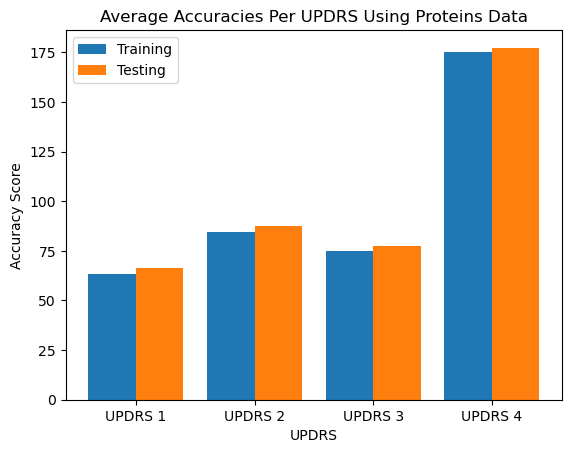

In [20]:
# create X axis
X = ["UPDRS 1", "UPDRS 2", "UPDRS 3", "UPDRS 4"]
X_axis = np.arange(len(X))

# create average lists for training and testing
average_training = []
average_training.append(sum(training_accuracy_list_1) / len(training_accuracy_list_1))
average_training.append(sum(training_accuracy_list_2) / len(training_accuracy_list_2))
average_training.append(sum(training_accuracy_list_3) / len(training_accuracy_list_3))
average_training.append(sum(training_accuracy_list_4) / len(training_accuracy_list_4))

average_testing = []
average_testing.append(sum(testing_accuracy_list_1) / len(testing_accuracy_list_1))
average_testing.append(sum(testing_accuracy_list_2) / len(testing_accuracy_list_2))
average_testing.append(sum(testing_accuracy_list_3) / len(testing_accuracy_list_3))
average_testing.append(sum(testing_accuracy_list_4) / len(testing_accuracy_list_4))

#print(average_training)
#print(average_testing)

# plot the accuracies
plt.bar(X_axis - 0.2, average_training, 0.4, label = "Training")
plt.bar(X_axis + 0.2, average_testing, 0.4, label = "Testing")

# label the plot
plt.xticks(X_axis, X)
plt.xlabel("UPDRS")
plt.ylabel("Accuracy Score")
plt.title("Average Accuracies Per UPDRS Using Proteins Data")
plt.legend()

# save the plot as a jpg file
plt.savefig("xgboost_proteins_score.jpg")

plt.show()

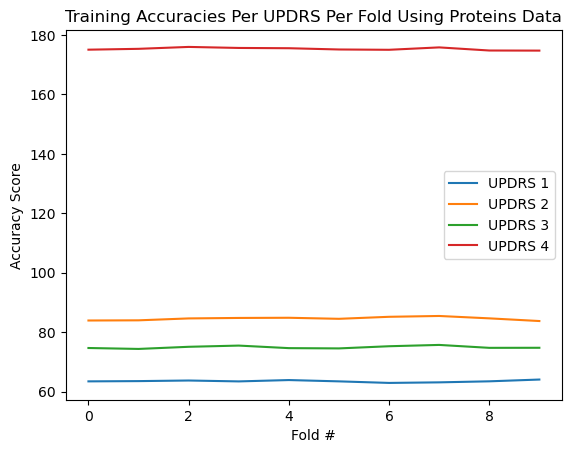

In [21]:
# create X axis
X = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
X_axis = np.arange(len(X))

# plot the accuracies
plt.plot(X_axis, training_accuracy_list_1, label = "UPDRS 1")
plt.plot(X_axis, training_accuracy_list_2, label = "UPDRS 2")
plt.plot(X_axis, training_accuracy_list_3, label = "UPDRS 3")
plt.plot(X_axis, training_accuracy_list_4, label = "UPDRS 4")

# label the plot
plt.title("Training Accuracies Per UPDRS Per Fold Using Proteins Data")
plt.xlabel("Fold #")
plt.ylabel("Accuracy Score")
plt.legend()

# save the plot as a jpg file
plt.savefig("xgboost_proteins_training_accuracies.jpg")

plt.show()

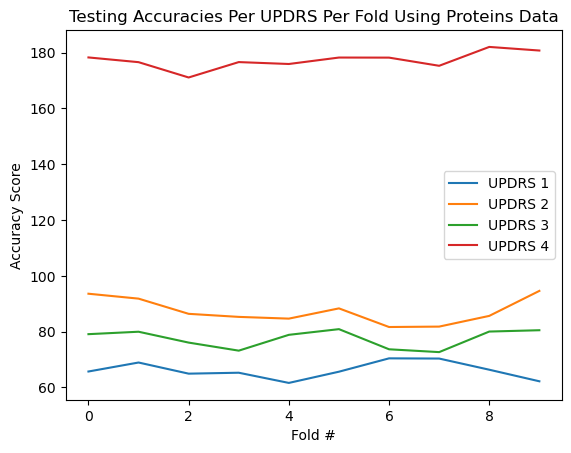

In [22]:
# create X axis
X = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
X_axis = np.arange(len(X))

# plot the accuracies
plt.plot(X_axis, testing_accuracy_list_1, label = "UPDRS 1")
plt.plot(X_axis, testing_accuracy_list_2, label = "UPDRS 2")
plt.plot(X_axis, testing_accuracy_list_3, label = "UPDRS 3")
plt.plot(X_axis, testing_accuracy_list_4, label = "UPDRS 4")

# label the plot
plt.title("Testing Accuracies Per UPDRS Per Fold Using Proteins Data")
plt.xlabel("Fold #")
plt.ylabel("Accuracy Score")
plt.legend()

# save the plot as a jpg file
plt.savefig("xgboost_proteins_testing_accuracies.jpg")

plt.show()

# **9. Preprocess the Peptides and Clinical Data**

In [23]:
train_peptides.head()

,visit_id,visit_month,patient_id,UniProt,Peptide,PeptideAbundance
0,55_0,0,55,O00391,NEQEQPLGQWHLS,11254.3
1,55_0,0,55,O00533,GNPEPTFSWTK,102060.0
2,55_0,0,55,O00533,IEIPSSVQQVPTIIK,174185.0
3,55_0,0,55,O00533,KPQSAVYSTGSNGILLC(UniMod_4)EAEGEPQPTIK,27278.9
4,55_0,0,55,O00533,SMEQNGPGLEYR,30838.7


In [24]:
# pivot the peptides data
_train_peptides = train_peptides.pivot(index = ['visit_id', 'visit_month', 'patient_id', 'UniProt'] , columns = 'Peptide' , values = 'PeptideAbundance').reset_index().rename_axis(None, axis = 1)
_train_peptides.head()

,visit_id,visit_month,patient_id,UniProt,AADDTWEPFASGK,AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K,AAFTEC(UniMod_4)C(UniMod_4)QAADK,AANEVSSADVK,AATGEC(UniMod_4)TATVGKR,AATVGSLAGQPLQER,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
0,10053_0,0,10053,O00391,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10053_0,0,10053,O00533,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10053_0,0,10053,O14773,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10053_0,0,10053,O14791,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10053_0,0,10053,O15240,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# merge patients
_train_peptides = _train_peptides.groupby(['visit_id', 'visit_month', 'patient_id']).sum().reset_index()
_train_peptides.head()

,visit_id,visit_month,patient_id,AADDTWEPFASGK,AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K,AAFTEC(UniMod_4)C(UniMod_4)QAADK,AANEVSSADVK,AATGEC(UniMod_4)TATVGKR,AATVGSLAGQPLQER,AAVYHHFISDGVR,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
0,10053_0,0,10053,6580710.0,31204.4,7735070.0,0.0,0.0,0.0,46620.3,...,202274.0,0.00,4401830.0,77482.6,583075.0,76705.7,104260.0,530223.0,0.0,7207.30
1,10053_12,12,10053,6333510.0,52277.6,5394390.0,0.0,0.0,0.0,57554.5,...,201009.0,0.00,5001750.0,36745.3,355643.0,92078.1,123254.0,453883.0,49281.9,25332.80
2,10053_18,18,10053,7129640.0,61522.0,7011920.0,35984.7,17188.0,19787.3,36029.4,...,220728.0,0.00,5424380.0,39016.0,496021.0,63203.6,128336.0,447505.0,52389.1,21235.70
3,10138_12,12,10138,7404780.0,46107.2,10610900.0,0.0,20910.2,66662.3,55253.9,...,188362.0,9433.71,3900280.0,48210.3,328482.0,89822.1,129964.0,552232.0,65657.8,9876.98
4,10138_24,24,10138,13788300.0,56910.3,6906160.0,13785.5,11004.2,63672.7,36819.8,...,206187.0,6365.15,3521800.0,69984.6,496737.0,80919.3,111799.0,0.0,56977.6,4903.09


In [26]:
_train_peptides = _train_peptides.dropna(axis = 1).drop(columns = ['visit_month', 'patient_id'])
_train_peptides.head()

,visit_id,AADDTWEPFASGK,AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K,AAFTEC(UniMod_4)C(UniMod_4)QAADK,AANEVSSADVK,AATGEC(UniMod_4)TATVGKR,AATVGSLAGQPLQER,AAVYHHFISDGVR,ADDKETC(UniMod_4)FAEEGK,ADDKETC(UniMod_4)FAEEGKK,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
0,10053_0,6580710.0,31204.4,7735070.0,0.0,0.0,0.0,46620.3,236144.0,0.0,...,202274.0,0.00,4401830.0,77482.6,583075.0,76705.7,104260.0,530223.0,0.0,7207.30
1,10053_12,6333510.0,52277.6,5394390.0,0.0,0.0,0.0,57554.5,108298.0,45885.4,...,201009.0,0.00,5001750.0,36745.3,355643.0,92078.1,123254.0,453883.0,49281.9,25332.80
2,10053_18,7129640.0,61522.0,7011920.0,35984.7,17188.0,19787.3,36029.4,708729.0,5067790.0,...,220728.0,0.00,5424380.0,39016.0,496021.0,63203.6,128336.0,447505.0,52389.1,21235.70
3,10138_12,7404780.0,46107.2,10610900.0,0.0,20910.2,66662.3,55253.9,79575.5,6201210.0,...,188362.0,9433.71,3900280.0,48210.3,328482.0,89822.1,129964.0,552232.0,65657.8,9876.98
4,10138_24,13788300.0,56910.3,6906160.0,13785.5,11004.2,63672.7,36819.8,34160.9,2117430.0,...,206187.0,6365.15,3521800.0,69984.6,496737.0,80919.3,111799.0,0.0,56977.6,4903.09


In [27]:
# merge the clinical and peptides data
merge_clinical_peptides = train_clinical.merge(_train_peptides, how = 'left', on = 'visit_id')

# drop the medication column as that is not needed
merge_clinical_peptides.drop(columns = ["upd23b_clinical_state_on_medication"], inplace = True)

# print data information
print("Merged Data has", merge_clinical_peptides.shape[0], "rows and", merge_clinical_peptides.shape[1], "columns")
merge_clinical_peptides.head()

Merged Data has 2615 rows and 975 columns


,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,AADDTWEPFASGK,AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K,AAFTEC(UniMod_4)C(UniMod_4)QAADK,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
0,55_0,55,0,10.0,6.0,15.0,0.0,8984260.0,53855.6,8579740.0,...,201158.0,16492.3,3810270.0,106894.0,580667.0,131155.0,165851.0,437305.0,46289.2,14898.4
1,55_3,55,3,10.0,7.0,25.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,55_6,55,6,8.0,10.0,34.0,0.0,8279770.0,45251.9,8655890.0,...,171079.0,13198.8,4119520.0,113385.0,514861.0,103512.0,144607.0,457891.0,40047.7,20703.9
3,55_9,55,9,8.0,9.0,30.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,55_12,55,12,10.0,10.0,41.0,0.0,8382390.0,53000.9,8995640.0,...,231772.0,17873.8,5474140.0,116286.0,711815.0,136943.0,181763.0,452253.0,54725.1,21841.1


In [28]:
merge_clinical_peptides = merge_clinical_peptides.dropna(axis = 0, how = 'all')
merge_clinical_peptides = merge_clinical_peptides.fillna(0)
merge_clinical_peptides.head()

,visit_id,patient_id,visit_month,updrs_1,updrs_2,updrs_3,updrs_4,AADDTWEPFASGK,AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K,AAFTEC(UniMod_4)C(UniMod_4)QAADK,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
0,55_0,55,0,10.0,6.0,15.0,0.0,8984260.0,53855.6,8579740.0,...,201158.0,16492.3,3810270.0,106894.0,580667.0,131155.0,165851.0,437305.0,46289.2,14898.4
1,55_3,55,3,10.0,7.0,25.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,55_6,55,6,8.0,10.0,34.0,0.0,8279770.0,45251.9,8655890.0,...,171079.0,13198.8,4119520.0,113385.0,514861.0,103512.0,144607.0,457891.0,40047.7,20703.9
3,55_9,55,9,8.0,9.0,30.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,55_12,55,12,10.0,10.0,41.0,0.0,8382390.0,53000.9,8995640.0,...,231772.0,17873.8,5474140.0,116286.0,711815.0,136943.0,181763.0,452253.0,54725.1,21841.1


In [29]:
# grab the number of features in the merged data (ignore the visit id, patient id, and visit month columns)
merge_features_peptides = merge_clinical_peptides.iloc[:, 7:]
merge_features_peptides.head()

,AADDTWEPFASGK,AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K,AAFTEC(UniMod_4)C(UniMod_4)QAADK,AANEVSSADVK,AATGEC(UniMod_4)TATVGKR,AATVGSLAGQPLQER,AAVYHHFISDGVR,ADDKETC(UniMod_4)FAEEGK,ADDKETC(UniMod_4)FAEEGKK,ADDLGKGGNEESTKTGNAGSR,...,YSLTYIYTGLSK,YTTEIIK,YVGGQEHFAHLLILR,YVM(UniMod_35)LPVADQDQC(UniMod_4)IR,YVMLPVADQDQC(UniMod_4)IR,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK
0,8984260.0,53855.6,8579740.0,0.0,19735.4,114400.0,46371.1,70412.0,7404060.0,39389.3,...,201158.0,16492.3,3810270.0,106894.0,580667.0,131155.0,165851.0,437305.0,46289.2,14898.4
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8279770.0,45251.9,8655890.0,49927.5,23820.4,90539.4,38652.4,63052.4,7344740.0,40871.1,...,171079.0,13198.8,4119520.0,113385.0,514861.0,103512.0,144607.0,457891.0,40047.7,20703.9
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8382390.0,53000.9,8995640.0,45519.2,17813.5,147312.0,45840.9,72325.0,6635000.0,35002.7,...,231772.0,17873.8,5474140.0,116286.0,711815.0,136943.0,181763.0,452253.0,54725.1,21841.1


In [30]:
merge_targets_peptides = merge_clinical_peptides.iloc[:, 3:7]
merge_targets_peptides.head()

,updrs_1,updrs_2,updrs_3,updrs_4
0,10.0,6.0,15.0,0.0
1,10.0,7.0,25.0,0.0
2,8.0,10.0,34.0,0.0
3,8.0,9.0,30.0,0.0
4,10.0,10.0,41.0,0.0


# **10. Create Model for Clinical and Peptides Data**

In [31]:
# create X and y
X = merge_features_peptides.values
y = merge_targets_peptides.values

# create 10 folds
k_folds = KFold(n_splits = 10, random_state = 1,shuffle = True)

# create accuracy lists
training_accuracy_list_1 = []
training_accuracy_list_2 = []
training_accuracy_list_3 = []
training_accuracy_list_4 = []
testing_accuracy_list_1 = []
testing_accuracy_list_2 = []
testing_accuracy_list_3 = []
testing_accuracy_list_4 = []

training_accuracy_list = []
testing_accuracy_list = []

# loop through the folds
for (train_index, test_index) in k_folds.split(X, y):
    # split the data into training and testing
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    
    #print(X_train)
    #print(y_train)
    #print(X_test)
    #print(y_test)
    #print("\n")
    
    # standardize the training and testing datasets
    sc = StandardScaler()
    sc.fit(X_train)
    X_train = sc.transform(X_train)
    X_test = sc.transform(X_test)
    
    
    # loop through the targets
    for i in range(4):
        # a list of parameters
        # max depth value shouldn't be larger or we'll overfit (same goes for subsample and colsample)
        param_grid = {
                'n_estimators': [400],
                'learning_rate': [0.01],
                'max_depth': [3],
                'subsample': [1],
                'colsample_bytree': [1]
            }
        
        # create the model
        model = GridSearchCV(xgb.XGBRegressor(tree_method = "gpu_hist"), param_grid, cv = 10)
        
        # fit the model per updrs
        model.fit(X_train, y_train[:, i])
        
        # grab the predictions
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        # calculate the accuracies (for smape, the lower the percentage the better)
        #training_accuracy = math.sqrt(mean_squared_error(y_train[:, i], y_pred_train))
        #testing_accuracy = math.sqrt(mean_squared_error(y_test[:, i], y_pred_test))
        training_accuracy = smape(y_train[:, i], y_pred_train)
        testing_accuracy = smape(y_test[:, i], y_pred_test)
        
        # store the accuracies at their respective lists
        if (i == 0):
            training_accuracy_list_1.append(training_accuracy)
            testing_accuracy_list_1.append(testing_accuracy)
        elif (i == 1):
            training_accuracy_list_2.append(training_accuracy)
            testing_accuracy_list_2.append(testing_accuracy)
        elif (i == 2):
            training_accuracy_list_3.append(training_accuracy)
            testing_accuracy_list_3.append(testing_accuracy)
        elif (i == 3):
            training_accuracy_list_4.append(training_accuracy)
            testing_accuracy_list_4.append(testing_accuracy)

In [32]:
print("Average Training Accuracy UPDRS 1: ", sum(training_accuracy_list_1) / len(training_accuracy_list_1))
print("Average Testing Accuracy UPDRS 1: ", sum(testing_accuracy_list_1) / len(testing_accuracy_list_1))

print("\nAverage Training Accuracy UPDRS 2: ", sum(training_accuracy_list_2) / len(training_accuracy_list_2))
print("Average Testing Accuracy UPDRS 2: ", sum(testing_accuracy_list_2) / len(testing_accuracy_list_2))

print("\nAverage Training Accuracy UPDRS 3: ", sum(training_accuracy_list_3) / len(training_accuracy_list_3))
print("Average Testing Accuracy UPDRS 3: ", sum(testing_accuracy_list_3) / len(testing_accuracy_list_3))

print("\nAverage Training Accuracy UPDRS 4: ", sum(training_accuracy_list_4) / len(training_accuracy_list_4))
print("Average Testing Accuracy UPDRS 4: ", sum(testing_accuracy_list_4) / len(testing_accuracy_list_4))

Average Training Accuracy UPDRS 1:  61.36379891337295
Average Testing Accuracy UPDRS 1:  65.52818684850506

Average Training Accuracy UPDRS 2:  82.21736919822102
Average Testing Accuracy UPDRS 2:  86.7516126914344

Average Training Accuracy UPDRS 3:  72.51932646772892
Average Testing Accuracy UPDRS 3:  77.00212015080004

Average Training Accuracy UPDRS 4:  173.99077664438514
Average Testing Accuracy UPDRS 4:  177.0393325676176


# **11. Graph the Accuracies**

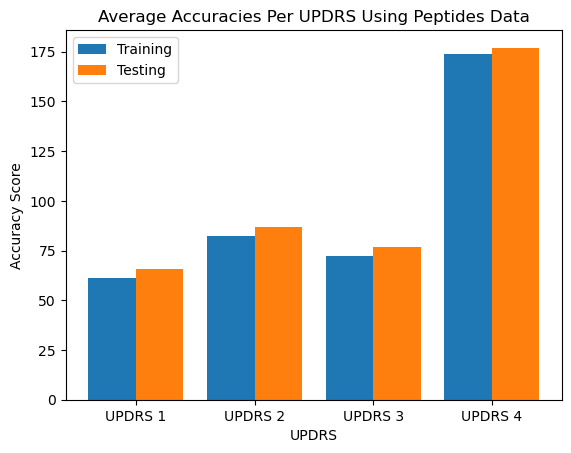

In [33]:
# create X axis
X = ["UPDRS 1", "UPDRS 2", "UPDRS 3", "UPDRS 4"]
X_axis = np.arange(len(X))

# create average lists for training and testing
average_training = []
average_training.append(sum(training_accuracy_list_1) / len(training_accuracy_list_1))
average_training.append(sum(training_accuracy_list_2) / len(training_accuracy_list_2))
average_training.append(sum(training_accuracy_list_3) / len(training_accuracy_list_3))
average_training.append(sum(training_accuracy_list_4) / len(training_accuracy_list_4))

average_testing = []
average_testing.append(sum(testing_accuracy_list_1) / len(testing_accuracy_list_1))
average_testing.append(sum(testing_accuracy_list_2) / len(testing_accuracy_list_2))
average_testing.append(sum(testing_accuracy_list_3) / len(testing_accuracy_list_3))
average_testing.append(sum(testing_accuracy_list_4) / len(testing_accuracy_list_4))

#print(average_training)
#print(average_testing)

# plot the accuracies
plt.bar(X_axis - 0.2, average_training, 0.4, label = "Training")
plt.bar(X_axis + 0.2, average_testing, 0.4, label = "Testing")

# label the plot
plt.xticks(X_axis, X)
plt.xlabel("UPDRS")
plt.ylabel("Accuracy Score")
plt.title("Average Accuracies Per UPDRS Using Peptides Data")
plt.legend()

# save the plot as a jpg file
plt.savefig("xgboost_peptides_score.jpg")

plt.show()

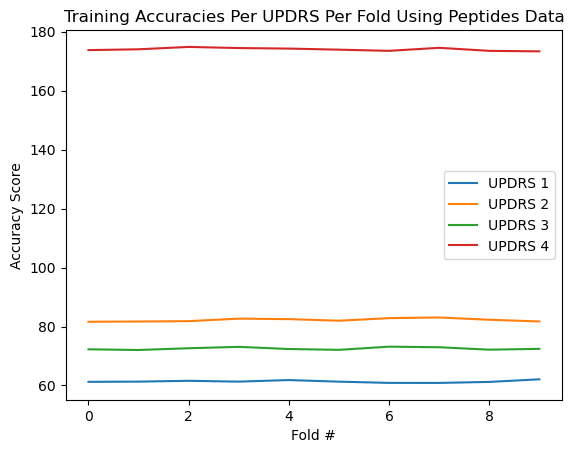

In [34]:
# create X axis
X = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
X_axis = np.arange(len(X))

# plot the accuracies
plt.plot(X_axis, training_accuracy_list_1, label = "UPDRS 1")
plt.plot(X_axis, training_accuracy_list_2, label = "UPDRS 2")
plt.plot(X_axis, training_accuracy_list_3, label = "UPDRS 3")
plt.plot(X_axis, training_accuracy_list_4, label = "UPDRS 4")

# label the plot
plt.title("Training Accuracies Per UPDRS Per Fold Using Peptides Data")
plt.xlabel("Fold #")
plt.ylabel("Accuracy Score")
plt.legend()

# save the plot as a jpg file
plt.savefig("xgboost_peptides_training_accuracies.jpg")

plt.show()

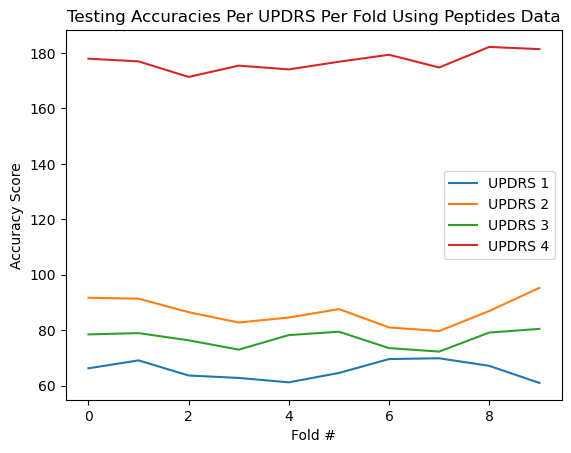

In [35]:
# create X axis
X = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
X_axis = np.arange(len(X))

# plot the accuracies
plt.plot(X_axis, testing_accuracy_list_1, label = "UPDRS 1")
plt.plot(X_axis, testing_accuracy_list_2, label = "UPDRS 2")
plt.plot(X_axis, testing_accuracy_list_3, label = "UPDRS 3")
plt.plot(X_axis, testing_accuracy_list_4, label = "UPDRS 4")

# label the plot
plt.title("Testing Accuracies Per UPDRS Per Fold Using Peptides Data")
plt.xlabel("Fold #")
plt.ylabel("Accuracy Score")
plt.legend()

# save the plot as a jpg file
plt.savefig("xgboost_peptides_testing_accuracies.jpg")

plt.show()